## Compute probability of missing a transfer from delays distributions

Let's first have a look at a slice of the dictionnary of distribution

In [1]:
import pickle 
import gzip
from itertools import islice
import matplotlib as mlt 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import math

In [2]:
# Functon to take a slice from a dictionnary - head equivalent
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

Load dictionnaries of distributions

In [53]:
with gzip.open("../data/distributions_geschaetzAndReal.pkl.gz", "rb") as input_file:
    d_real = pickle.load(input_file)

with gzip.open("../data/distributions.pickle", "rb") as input_file:
    d_all = pickle.load(input_file)

# display a slice of it
print('len dict_real : ', len(d_real))
print(take(5, d_real.items()))

# display a slice of it
print('len dict_all : ', len(d_all))
print(take(5, d_all.items()))

len dict_real :  12309
[('10.TA.1-11-B-j19-1.1.R__8590314', array([0, 2, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('10.TA.1-11-B-j19-1.1.R__8590317', array([0, 3, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('10.TA.1-11-B-j19-1.1.R__8594304', array([0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('10.TA.1-11-B-j19-1.1.R__8594307', array([0, 1, 5, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('10.TA.1-11-B-j19-1.1.R__8594310', array([0, 1, 3, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]
len dict_all :  246968
[('1286.TA.26-32-j19-1.12.H__8591182', array([   0, 1158,  306,  162,   94,   24,   28,   21,    3,    2,    0,
          1,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,
          0,    0,    0

### Probability using cumulative distribution based on frequency of delays 

When we have __enough data__ and no ambiguity about `trip_id` and `stop_id` for a given distribution, then we can compute the probability $P(x \leq X)$ for every x (delay in minute). 

Let's take a __threshold of 100__ sample points (=number of time we could measure a delay) as a minimum number of points to use this approach. 

_How many keys in our distionnary of distribution have at least this number of samples ?_

In [4]:
def plot_data_points_hist(dico):
    list_tot_points = []
    for key in dico:
        distrib = dico[key]
        list_tot_points.append(np.sum(distrib))

    tot_per_key = np.array(list_tot_points)
    binwidth = 100
    n_keys_less_than_binwidth = np.sum(np.array(tot_per_key < binwidth))
    perc_key_to_recover = round(100 * ( n_keys_less_than_binwidth / len(tot_per_key) ), 2)
    plt.figure(figsize = (10,5))
    plt.hist(tot_per_key, bins = range(min(tot_per_key), max(tot_per_key) + binwidth, binwidth))
    plt.title("Total number of data points per trip_id / stop_id key. N keys with less than {0} points: {1} ({2}%)"\
             .format(binwidth, n_keys_less_than_binwidth, perc_key_to_recover))
    plt.xlabel('n data points')
    plt.ylabel('n keys')
    return plt.show()

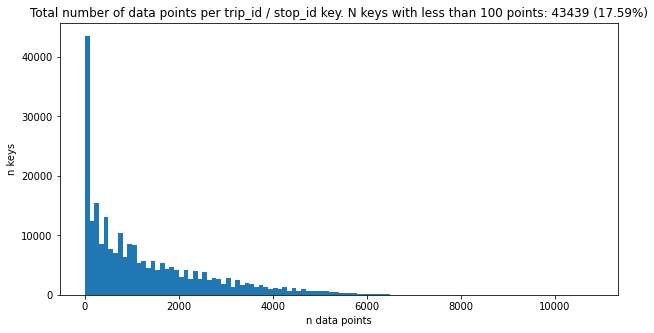

In [5]:
plot_data_points_hist(d_all)

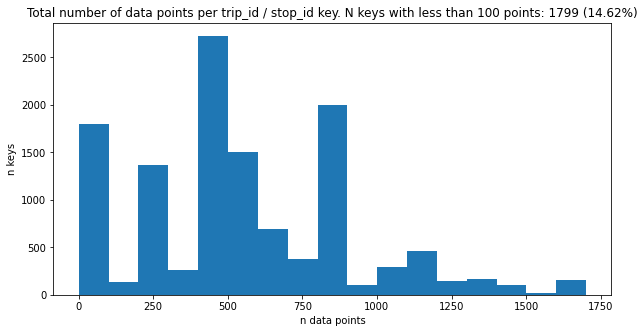

In [6]:
plot_data_points_hist(d_real)

First we generate a dictionnary with cumulative probability based on frequency of delays, for each keys in our reference dictionnary.

In [7]:
def cumul_distri_probas_dict(dico):
    list_tot_points = []
    for key in dico:
        distrib = dico[key]

        # get total number of elements 
        N = np.sum(distrib)

        # make cumulative distribution probabilities
        cdf_distrib = np.empty((len(distrib)), dtype=float)
        save_x = 0
        for x in range(len(distrib)):
            cdf_distrib[x] = float(distrib[x])/float(N) + float(save_x)/float(N)
            save_x += distrib[x]

        dico[key] = cdf_distrib
    return dico

In [8]:
d_all_cdp = cumul_distri_probas_dict(d_all)
take(3, d_all_cdp.items())

[('1286.TA.26-32-j19-1.12.H__8591182',
  array([0.        , 0.64333333, 0.81333333, 0.90333333, 0.95555556,
         0.96888889, 0.98444444, 0.99611111, 0.99777778, 0.99888889,
         0.99888889, 0.99944444, 0.99944444, 0.99944444, 0.99944444,
         0.99944444, 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        ])),
 ('1286.TA.26-32-j19-1.12.H__8591184',
  array([5.56483027e-04, 4.24596550e-01, 7.31775181e-01, 8.94268225e-01,
         9.59933222e-01, 9.86644407e-01, 9.93878687e-01, 9.98330551e-01,
         9.98330551e-01, 9.98887034e-01, 9.99443517e-01, 9.99443517e-01,
         9.99443517e-01, 9.99443517e-01, 9.99443517e-01, 9.99443517e-01,
         9.99443517e-01, 9.99443517e-01, 9.99443517e-01, 9.99443517e-01,
         9.99443517e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.0000000

In [9]:
d_real_cdp = cumul_distri_probas_dict(d_real)
take(3, d_real_cdp.items())

[('10.TA.1-11-B-j19-1.1.R__8590314',
  array([0.   , 0.25 , 0.5  , 0.625, 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   , 1.   , 1.   , 1.   , 1.   ])),
 ('10.TA.1-11-B-j19-1.1.R__8590317',
  array([0. , 0.3, 0.5, 0.7, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. ])),
 ('10.TA.1-11-B-j19-1.1.R__8594304',
  array([0. , 0. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. ]))]

In [10]:
# write dictionnary 
with gzip.open("../data/distributions_cumulative_real.pkl.gz", "wb") as output_file:
    pickle.dump(d_real_cdp, output_file)

In [11]:
# write dictionnary 
with gzip.open("../data/distributions_cumulative.pickle", "wb") as output_file:
    pickle.dump(d, output_file)

NameError: name 'd' is not defined

### Construct recovery tables 

First approach is to simple sum up similar distribution to get a new distribution we can use. For that, we need to have transport type (`route_desc`), `time` (rounded to hour) and `stop_id` which are valid. We then make all combination of these tree parameters and get the associate distributions

In [12]:
with open("../data/stop_times_df.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
stoptimes.head()

route_int  trip_int  stop_int  stop_sequence        arrival_time  \
0          0         0         0              1                 NaT   
1          0         0         1              2 2020-05-21 07:23:00   
2          0         0         2              3 2020-05-21 07:29:00   
3          0         1         0              1                 NaT   
4          0         1         1              2 2020-05-21 07:53:00   

       departure_time       route_id                 trip_id  stop_id  \
0 2020-05-21 07:18:00  30-57-Y-j19-1  4.TA.30-57-Y-j19-1.1.H  8502208   
1 2020-05-21 07:23:00  30-57-Y-j19-1  4.TA.30-57-Y-j19-1.1.H  8502209   
2                 NaT  30-57-Y-j19-1  4.TA.30-57-Y-j19-1.1.H  8503202   
3 2020-05-21 07:48:00  30-57-Y-j19-1  5.TA.30-57-Y-j19-1.1.H  8502208   
4 2020-05-21 07:53:00  30-57-Y-j19-1  5.TA.30-57-Y-j19-1.1.H  8502209   

  route_desc stop_id_raw  sequence_shift_1  
0        Bus     8502208                 2  
1        Bus     8502209                 3  
2        Bus     8503202                 1  
3        Bus     8502208                 2  
4        Bus     8502209                 3

In [13]:
# Set same stoptimes index as distribution dict 
stoptimes['stop_id'] = stoptimes['stop_id'].astype(str).str[0:7]
stoptimes['key'] = stoptimes['trip_id'] + '__' + stoptimes['stop_id']
stoptimes = stoptimes.set_index('key')

stoptimes = stoptimes[['trip_id','stop_id', 'route_desc', 'arrival_time', 'departure_time']]

list_hours = []
size_stop_times = stoptimes.shape[0]
for x in range(size_stop_times):
    if (x % 10000) == 0 :
        print('{}%'.format(round(100*x/size_stop_times,2)), end = ', ')
    
    arr_time_hour = pd.to_datetime(stoptimes.iloc[x,:]['arrival_time']).hour
    if math.isnan(arr_time_hour): # if arrival is NaT, use departure time
        arr_time_hour = pd.to_datetime(stoptimes.iloc[x,:]['departure_time']).hour
    list_hours.append(int(arr_time_hour))
    
stoptimes['hour'] = list_hours
stoptimes = stoptimes.drop(columns=['trip_id', 'arrival_time', 'departure_time'])

# Write this pickle to avoid re-running this above code all the time
with gzip.open("../data/stop_times_wHour.pkl", "wb") as output_file:
    pickle.dump(stoptimes, output_file)         
              

0.0%, 4.07%, 8.14%, 12.21%, 16.28%, 20.35%, 24.42%, 28.49%, 32.55%, 36.62%, 40.69%, 44.76%, 48.83%, 52.9%, 56.97%, 61.04%, 65.11%, 69.18%, 73.25%, 77.32%, 81.39%, 85.46%, 89.53%, 93.6%, 97.66%, 

In [15]:
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
distrib_df = pd.DataFrame(d_all).transpose()
distrib_to_rm = np.array(distrib_df.iloc[:,range(11)].sum(axis=1) == 11) # missing trips
distrib_df = distrib_df.iloc[~distrib_to_rm,:]

stoptimes_df = pd.DataFrame(stoptimes)

recovery_df = distrib_df.join(stoptimes_df)
list_bins = [x for x in range(32)]

recovery_df = recovery_df.groupby(['stop_id','hour', 'route_desc'])[list_bins].apply(lambda x : x.astype(float).sum())
recovery_df = recovery_df.astype('int')
print(recovery_df.shape)
recovery_df.head(4)

(17321, 32)


0   1   2   3   4   5   6   7   8   9   ...  22  23  \
stop_id hour route_desc                                          ...           
8500926 8.0  Bus          0   2   3   3   4   4   4   4   4   4  ...   4   4   
        9.0  Bus          0   1   2   2   2   2   2   2   2   2  ...   2   2   
        10.0 Bus          0   0   1   1   1   1   1   2   2   2  ...   2   2   
        11.0 Bus          0   0   1   1   1   2   2   2   2   2  ...   2   2   

                         24  25  26  27  28  29  30  31  
stop_id hour route_desc                                  
8500926 8.0  Bus          4   4   4   4   4   4   4   4  
        9.0  Bus          2   2   2   2   2   2   2   3  
        10.0 Bus          2   2   2   2   2   2   2   2  
        11.0 Bus          2   2   2   2   2   2   2   2  

[4 rows x 32 columns]

In [16]:
def plot_df_missing(df, max_bin = 10000):
    tot_per_key = np.array(df.sum(axis=1)).astype('int')
    binwidth = 100
    n_keys_less_than_binwidth = np.sum(np.array(tot_per_key < binwidth))
    perc_key_to_recover = round(100 * ( n_keys_less_than_binwidth / len(tot_per_key) ), 2)
    plt.figure(figsize = (10,5))
    plt.hist(tot_per_key, bins = range(min(tot_per_key), max_bin + binwidth, binwidth))
    plt.title("Total number of data points per stop_id / hour key. N keys with less than {0} points: {1} ({2}%)"\
             .format(binwidth, n_keys_less_than_binwidth, perc_key_to_recover))
    plt.xlabel('n data points')
    plt.ylabel('n keys')
    return plt.show()

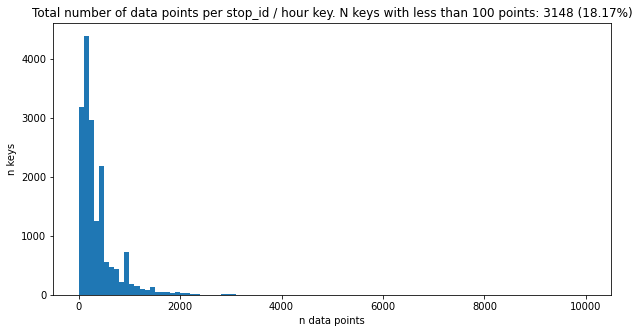

In [17]:
plot_df_missing(recovery_df)

In [18]:
recovery_df.head(20)

0   1   2   3   4   5   6   7   8   9   ...  22  23  \
stop_id hour route_desc                                          ...           
8500926 8.0  Bus          0   2   3   3   4   4   4   4   4   4  ...   4   4   
        9.0  Bus          0   1   2   2   2   2   2   2   2   2  ...   2   2   
        10.0 Bus          0   0   1   1   1   1   1   2   2   2  ...   2   2   
        11.0 Bus          0   0   1   1   1   2   2   2   2   2  ...   2   2   
        12.0 Bus          0   0   1   1   1   2   2   2   2   2  ...   2   2   
        13.0 Bus          0   0   1   1   1   2   2   2   2   2  ...   2   2   
        14.0 Bus          0   0   1   1   2   2   2   2   2   2  ...   2   2   
        15.0 Bus          0   0   1   1   2   2   2   2   2   2  ...   2   2   
        16.0 Bus          0   1   3   3   3   3   3   4   4   4  ...   4   4   
        17.0 Bus          0   1   3   3   3   3   3   3   3   3  ...   4   4   
        18.0 Bus          0   2   3   3   3   3   3   3   3   3  ...   4   4   
        19.0 Bus          0   2   2   2   2   3   3   3   3   3  ...   3   3   
8502186 8.0  S-Bahn       0   3   6   7   7   7   7   7   7   7  ...   8   8   
        9.0  S-Bahn       0   4   7   7   7   7   7   7   7   7  ...   8   8   
        10.0 S-Bahn       0   4   7   7   7   7   7   7   7   7  ...   7   7   
        11.0 S-Bahn       0   4   7   7   7   7   7   7   7   7  ...   7   7   
        12.0 S-Bahn       0   3   7   7   7   7   7   7   7   7  ...   7   7   
        13.0 S-Bahn       0   3   7   7   7   7   7   7   7   7  ...   8   8   
        14.0 S-Bahn       0   3   7   7   7   7   7   7   7   7  ...   8   8   
        15.0 S-Bahn       0   3   7   7   7   7   7   7   7   7  ...   7   7   

                         24  25  26  27  28  29  30  31  
stop_id hour route_desc                                  
8500926 8.0  Bus          4   4   4   4   4   4   4   4  
        9.0  Bus          2   2   2   2   2   2   2   3  
        10.0 Bus          2   2   2   2   2   2   2   2  
        11.0 Bus          2   2   2   2   2   2   2   2  
        12.0 Bus          2   2   2   2   2   2   2   2  
        13.0 Bus          2   2   2   2   2   2   2   2  
        14.0 Bus          2   2   2   2   2   2   2   2  
        15.0 Bus          2   2   2   2   2   2   2   2  
        16.0 Bus          4   4   4   4   4   4   4   4  
        17.0 Bus          4   4   4   4   4   4   4   4  
        18.0 Bus          4   4   4   4   4   4   4   4  
        19.0 Bus          3   3   3   3   3   3   3   3  
8502186 8.0  S-Bahn       8   8   8   8   8   8   8   8  
        9.0  S-Bahn       8   8   8   8   8   8   8   8  
        10.0 S-Bahn       7   7   7   8   8   8   8   8  
        11.0 S-Bahn       7   7   7   7   7   7   7   8  
        12.0 S-Bahn       7   7   7   7   7   7   7   8  
        13.0 S-Bahn       8   8   8   8   8   8   8   8  
        14.0 S-Bahn       8   8   8   8   8   8   8   8  
        15.0 S-Bahn       7   7   7   7   7   7   8   8  

[20 rows x 32 columns]

#### Make second recovery table

Here only taking combination of `transport_type x hour`

In [19]:
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
distrib_df = pd.DataFrame(d_all).transpose()
distrib_to_rm = np.array(distrib_df.iloc[:,range(11)].sum(axis=1) == 11) # missing trips
distrib_df = distrib_df.iloc[~distrib_to_rm,:]

stoptimes_df = pd.DataFrame(stoptimes)

recovery_df2 = distrib_df.join(stoptimes_df)
list_bins = [x for x in range(32)]

recovery_df2 = recovery_df2.groupby(['hour', 'route_desc'])[list_bins].apply(lambda x : x.astype(float).sum())
recovery_df2 = recovery_df2.astype('int')
print(recovery_df2.shape)
recovery_df2.head(4)

(127, 32)


0   1   2   3   4   5   6   7   8   9   ...  22  23  24  25  \
hour route_desc                                          ...                   
7.0  Bus          0   5   7   9   9  10  10  10  11  11  ...  11  12  12  12   
     InterRegio   0   0   0   0   0   1   1   1   1   1  ...   2   2   2   2   
     Intercity    0   0   0   0   0   1   1   1   1   1  ...   2   2   2   2   
     S-Bahn       0   3   5   6   7   8   8   8   9   9  ...   9   9   9   9   

                 26  27  28  29  30  31  
hour route_desc                          
7.0  Bus         12  12  12  12  12  12  
     InterRegio   2   2   2   2   2   2  
     Intercity    2   2   2   2   2   2  
     S-Bahn       9   9  10  10  10  10  

[4 rows x 32 columns]

### Last recovery table 

Takes only transport type distribution

In [20]:
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
distrib_df = pd.DataFrame(d_all).transpose()
distrib_to_rm = np.array(distrib_df.iloc[:,range(11)].sum(axis=1) == 11) # missing trips
distrib_df = distrib_df.iloc[~distrib_to_rm,:]

stoptimes_df = pd.DataFrame(stoptimes)

recovery_df3 = distrib_df.join(stoptimes_df)
list_bins = [x for x in range(32)]

recovery_df3 = recovery_df3.groupby(['route_desc'])[list_bins].apply(lambda x : x.astype(float).sum())
recovery_df3 = recovery_df3.astype('int')
print(recovery_df3.shape)
recovery_df3.head(4)

(11, 32)


0      1      2       3       4       5       6       7   \
route_desc                                                               
Bus         1572  59211  97405  115766  124269  128687  131397  133346   
Eurocity       0      0      0       1       1       1       1       2   
InterRegio    33     74    107     141     174     207     240     273   
Intercity      9     19     29      39      49      59      69      79   

                8       9   ...      22      23      24      25      26  \
route_desc                  ...                                           
Bus         134908  136278  ...  137998  138003  138007  138012  138014   
Eurocity         2       2  ...       3       3       3       3       3   
InterRegio     306     339  ...     371     371     371     372     372   
Intercity       89      99  ...     109     109     109     109     109   

                27      28      29      30      31  
route_desc                                          
Bus         138016  138018  138021  138023  138087  
Eurocity         3       3       3       3       3  
InterRegio     372     372     372     372     372  
Intercity      109     109     109     109     109  

[4 rows x 32 columns]

### Reconstruct cumulative distribution probabilities from multiple distributions to recover data with few/missing points 

To recover missing or faulty data, the strategy is the following :
1. If we have more than 100 data points in `real` group, we rely exclusively on it to compute probabilities for a given transfer on a `trip_id x stop_id` 
    - `real` group : the delay was calculated with actual arrival time with status `geschaetz` or `real`, meaning it comes from actual measurments.
2. If we do not find enough data within `real` group, we look at distributions in `all` group (contains all delays including `prognose` status) to compute probabilities, if there is more than 100 data points for a given `trip_id x stop_id`.
3. If `all` group still does not have more than 100 data points, we rely on `recovery tables` to estimate delay distributions. The strategy is the following :
    - As we will always know the `stop_id`, the `time` and the `transport_type`, we rely on arrival delays from aggregated values of similar transfer. 
        - First, we compute a table of distribution with all possible combination of `stop_id`, `time` (round to hours) and `transport_type`, and aggregate all the counts we have to compute cumulative distribution probabilities. 
        - Is there is less than 100 data points in one of these intersections, we use the last possibilities : a table with `transport_type` x `time` aggregate counts.
        - The last values with no match are given the overall average of cumulative distribution probabilities for each `transport_type` with no limit for the minimum number of data points.

Following this approach, we can find cumulative distribution probabilities for every combination of `trip_id x stop_id` as defined in `stop_times_df`. We will make a table with the same row order so that McRaptor can easily find their indexes. 

In order to do that, we have two dictionnaries of distributions and two recovery dataframes :
 - `df_real` : contains delay distribution for each keys in form `trip_id + __ + stop_id` calculated from delays with status `geschaetz` or `real` in sbb datasets.
 - `df_all` : contains delay distributions for each keys in form `trip_id + __ + stop_id`. No filter was applied on status (contains `geschaetz`, `real` __and__ `prognose` = evaluated delay).
 - `recovery_df` : contains aggregated delay distributions for each combination of `stop_id`, `route_desc` (transport type) and `hour` (time rounded to hour). 
 - `recovery_df2` : contains aggregated delay distributions for each combination of `route_desc` (transport type) and `hour` (time rounded to hour). 
 - `recovery_df3` : contains aggregated delay distributions for `route_desc` (transport type) 

In [21]:
###################### MAKE CUMULATIVE PROBABILITY TABLE #######################

# Load stop_time table, to use its order as a template for our final table 
with open("../data/stop_times_df.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
stoptimes.head(3)

route_int  trip_int  stop_int  stop_sequence        arrival_time  \
0          0         0         0              1                 NaT   
1          0         0         1              2 2020-05-21 07:23:00   
2          0         0         2              3 2020-05-21 07:29:00   

       departure_time       route_id                 trip_id  stop_id  \
0 2020-05-21 07:18:00  30-57-Y-j19-1  4.TA.30-57-Y-j19-1.1.H  8502208   
1 2020-05-21 07:23:00  30-57-Y-j19-1  4.TA.30-57-Y-j19-1.1.H  8502209   
2                 NaT  30-57-Y-j19-1  4.TA.30-57-Y-j19-1.1.H  8503202   

  route_desc stop_id_raw  sequence_shift_1  
0        Bus     8502208                 2  
1        Bus     8502209                 3  
2        Bus     8503202                 1

In [67]:
summary_df = pd.DataFrame(columns = ['key', 'key_int', 'trip_id', 'stop_id', 'transport_type', 'hour', 'distribution'])
n_fail = 0
size_stop_times = stoptimes.shape[0]
n_real = 0
n_all  = 0
n_recov1 = 0
n_recov2 = 0
n_recov3 = 0
all_distrib = []
all_transport_type = []
all_hours = []
all_keys = []

i = 0
for index, row in stoptimes.iterrows():
    
    trip_id = row[7]
    stop_id = str(row[8])[:7]
    transport_type = row[9]
    key = trip_id + '__' + stop_id

    # Compute rounded hour using arrival if possible - recover with departure
    hour = pd.to_datetime(stoptimes.loc[index]['arrival_time']).hour
    if math.isnan(hour): # if arrival is NaT, use departure time
        hour = pd.to_datetime(stoptimes.loc[index]['departure_time']).hour
    
    distrib = np.zeros(31)
    keep_trying = True
    
    # 1) try d_real to get distribution from measured delays
    if key in d_real:
        distrib = d_real[key]
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_real += 1
    
    # 2) try d_all to get distribution from measured + estimated delays
    if keep_trying and key in d_all:
        distrib = d_all[key]
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False
            n_all += 1
            
    # 3) try first recovery table using stop_id, transport_type and hour
    if keep_trying and (stop_id, hour, transport_type) in recovery_df.index:
        distrib = np.array(recovery_df.loc[(stop_id, hour, transport_type)])
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_recov1 += 1
            
    # 4) use second recovery table using transport_type and hour 
    if keep_trying and (hour, transport_type) in recovery_df2.index:
        distrib = np.array(recovery_df2.loc[(hour, transport_type)])
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_recov2 += 1
    
    # 5) use third recovery table using transport_type only 
    if keep_trying and (transport_type) in recovery_df3.index:
        distrib = np.array(recovery_df3.loc[(transport_type)])
        sum_distrib = np.sum(distrib)
        #summary_df.loc[index, 'distribution'] = distrib
        all_distrib.append(distrib)
        keep_trying = False 
        n_recov3 += 1
            
    # Record results in summary
    #summary_df.loc[index, 'key'] = key
    #summary_df.loc[index, 'key_int'] = index
    #summary_df.loc[index, 'trip_id'] = trip_id
    #summary_df.loc[index, 'stop_id'] = stop_id
    #summary_df.loc[index, 'transport_type'] = transport_type
    #summary_df.loc[index, 'hour'] = hour
    all_keys.append(key)
    all_transport_type.append(transport_type)
    all_hours.append(hour)

    # save number of failure for recovery
    if keep_trying:
        print('fail{}'.format(index), end = ', ')
        n_fail += 1 
        
    # print progression 
    if (index % 10000) == 0 :
        print('{}%'.format(round(100*index/size_stop_times,2)), end = ', ')

0.0%, 4.07%, 8.14%, 12.21%, 16.28%, 20.35%, 24.42%, 28.49%, 32.55%, 36.62%, 40.69%, 44.76%, 48.83%, 52.9%, 56.97%, 61.04%, 65.11%, 69.18%, 73.25%, 77.32%, 81.39%, 85.46%, 89.53%, 93.6%, 97.66%, 

In [68]:
print(n_real)
print(n_all)
print(n_recov1)
print(n_recov2)
print(n_recov3)

10422
173225
37031
20853
4207


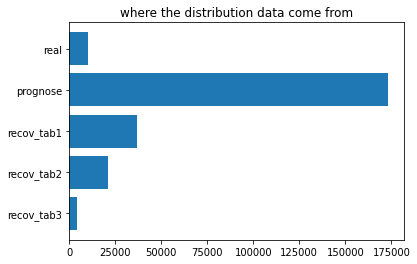

In [82]:
plt.barh(np.array(['real','prognose','recov_tab1','recov_tab2','recov_tab3'])[::-1],\
         np.array([n_real,n_all,n_recov1,n_recov2, n_recov3])[::-1])
plt.title('where the distribution data come from')
plt.show()

In [83]:
summary_df = pd.DataFrame([all_keys, all_hours, all_transport_type, all_distrib],\
                          index = ['key','hour','transport_type','distribution']).transpose()
summary_df.head()

key hour transport_type  \
0  4.TA.30-57-Y-j19-1.1.H__8502208    7            Bus   
1  4.TA.30-57-Y-j19-1.1.H__8502209    7            Bus   
2  4.TA.30-57-Y-j19-1.1.H__8503202    7            Bus   
3  5.TA.30-57-Y-j19-1.1.H__8502208    7            Bus   
4  5.TA.30-57-Y-j19-1.1.H__8502209    7            Bus   

                                        distribution  
0  [0, 5, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11...  
1  [0, 5, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11...  
2  [0, 5, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11...  
3  [0, 5, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11...  
4  [0, 5, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11...

In [84]:
# Load stop_time table, to use its order as a template for our final table 
with gzip.open("../data/join_distribution_all.pkl.gz", "wb") as out_file:
    pickle.dump(summary_df, out_file)

In [85]:
list_all_rows = []
for index, row in summary_df.iterrows():
    distrib = np.array(row['distribution'])
    
    # get total number of elements 
    N = np.sum(distrib)
        
    # make cumulative distribution probabilities
    cdf_distrib = np.empty((len(distrib)), dtype=float)
    save_x = 0
    for x in range(len(distrib)):
        cdf_distrib[x] = float(distrib[x])/float(N) + float(save_x)/float(N)
        save_x += distrib[x]
        
    list_all_rows.append(cdf_distrib)

In [86]:
final_df = pd.DataFrame(list_all_rows)
final_df.index = summary_df.index
final_np = final_df.to_numpy()
final_np[0:5,:]

array([[0.        , 0.01501502, 0.03603604, 0.06306306, 0.09009009,
        0.12012012, 0.15015015, 0.18018018, 0.21321321, 0.24624625,
        0.27927928, 0.31231231, 0.34534535, 0.37837838, 0.41141141,
        0.44444444, 0.47747748, 0.51051051, 0.54354354, 0.57657658,
        0.60960961, 0.64264264, 0.67567568, 0.71171171, 0.74774775,
        0.78378378, 0.81981982, 0.85585586, 0.89189189, 0.92792793,
        0.96396396, 1.        ],
       [0.        , 0.01501502, 0.03603604, 0.06306306, 0.09009009,
        0.12012012, 0.15015015, 0.18018018, 0.21321321, 0.24624625,
        0.27927928, 0.31231231, 0.34534535, 0.37837838, 0.41141141,
        0.44444444, 0.47747748, 0.51051051, 0.54354354, 0.57657658,
        0.60960961, 0.64264264, 0.67567568, 0.71171171, 0.74774775,
        0.78378378, 0.81981982, 0.85585586, 0.89189189, 0.92792793,
        0.96396396, 1.        ],
       [0.        , 0.01501502, 0.03603604, 0.06306306, 0.09009009,
        0.12012012, 0.15015015, 0.18018018, 0.2132

In [87]:
sum(np.array(final_df.index == stoptimes.index)) == stoptimes.shape[0]

True

In [88]:
# write recovery table 
with gzip.open("../data/join_distribution_cumulative_p_2.pkl.gz", "wb") as output_file:
    pickle.dump(final_np, output_file)

### Poisson cumulative distribution

The Poisson distribution is popular for modeling the number of times an event occurs in an interval of time or space. We modeled a poisson distribution for delays assuming parameter $k$ is the time in minutes (as it was done [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126137), formulas $(4),(5),(6)$).

A discrete random variable X is said to have a Poisson distribution with parameter λ > 0, if, for k = 0, 1, 2, ..., the probability mass function of X is given by:

$${\displaystyle \!f(k;\lambda )=\Pr(X=k)={\frac {\lambda ^{k}e^{-\lambda }}{k!}},}$$
where

e is Euler's number (e = 2.71828...)
k! is the factorial of k.
The positive real number λ is equal to the expected value of X __and__ to its variance.

$${\displaystyle \lambda =\operatorname {E} (X)=\operatorname {Var} (X)}$$

We can approximate E[𝑋]∼$\mu_i$ for our data $X_i$, if we assume the sample $X_i$ of size N follow the distribution of $X$ meaning $X_i$∼$X$.

Poisson-related __assumptions__ :
- $k$ is the __delay time in minutes__ and can take values 0, 1, 2, ... (strictly positive and discrete)
- We assume our sampling $X_i$ of $X$ is good enough to approximate E[X] ~ $\mu_i$
- The occurrence of one event does not affect probability of others. That is, events occur independently.
    - __We assume being late one day is not affecting the delay of the day after__ 
- The average rate at which events occur is independent of any occurrences. For simplicity, this is usually assumed to be constant, but may in practice vary with time.
    - __we assumes delays occurs with a constant rate over time__
- Two events cannot occur at exactly the same instant

We made a function `poisson_proba` that takes a `trip_id`, a `stop_id`, an `arrival time` and a `departure time` and a dictionnary {key : distribution} to compute a __probability to be at least 2 minutes before departure of next trip__. 

We make a few __assumptions__ on our side :
- We assume that if we have less than 2 minutes for the transfer, we miss it.
- We assume the next train is on time.
- As for poisson distribution $k$ is strictly positive, we assume trains ahead of schedule were on time ($k=0$)


_Question we should address :_
- _Is the poisson a reasonable approximation of the binomial distribution in our case ?_

Let's first test the poisson distribution and compare it with our distribution to see how well it fits the data. We will compute $Pr(X = k)$ for each values of k and look at the shape of the poisson distribution compared to the shape of our scaled data. Then, we will compare $\sum_{k=0}^T Pr(X = k)$ with the cumulative distribution function which directly gives $Pr(k \leq X)$

In [22]:
################################# POISSON FIT TEST #########################################

# to do .. 


An error was encountered:
Invalid status code '404' from http://iccluster044.iccluster.epfl.ch:8998/sessions/6821 with error payload: "Session '6821' not found."


Here are all the functions needed to calculate probability of success for a given transfer. We need the `trip_id`, `stop_id`, `departure_time`, `arrival_time` and dictionnary `d` (pickled load at the beginning of the cell) to be able to compute a probability of success with following function : 

`poisson_proba(trip_id, stop_id, arrival_time, departure_time, d)`

In [40]:
%local
################################# POISSON FUNCTIONS ########################################

import pickle 
import gzip
import time
import math 
import datetime
import time
from scipy.stats import poisson

# Load dictionnary
with gzip.open("../data/distributions.pickle", "rb") as input_file:
    d = pickle.load(input_file)

# Load dictionnary
with open("../data/stop_times_array.pkl", "rb") as input_file:
    times = pickle.load(input_file)

# we take two exemple time in format numpy.datetime64
arr_time = times[4][1]
dep_time = times[0][1]

# Load distribution in dictinonary given a key
def get_distrib(key, dico):
    if key in dico:
        return dico[key]
    else:
        raise ValueError("KEY ERROR: {} not found un distribution dictionnary".format(key))
    
# Evaluate lambda parameter assuming it is equal to average 
def evaluate_lamda(distrib):
    # First calculate total number of measures N
    N = 0 # by starting at -1 we ignore trains ahead of schedule
    for x in distrib:
        N += x

    lambda_p = 0 # expectation - we want to calculate it
    t        = -1 # time = index - 1

    for x in distrib:
        if t>0:
            lambda_p += t*x
        t += 1

    # calculate lambda - the expectation of x
    if N > 0:
        lambda_p /= N 
        print('lambda (expectation given distribution): ',lambda_p, '\n')
        return lambda_p
    else : 
        raise ValueError("ERROR : {} distribution has 0 counts".format(key))
        #print('Returning 1 to avoid later problem... \n')
        return 1

# process time given as string in format 'hh:mm' - not needed
def process_time_str(str_time):
    x = time.strptime(str_time,'%H:%M')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

# Calculate transfer time given two times in string format 'hh:mm'
def get_transfer_time(arr_time, dep_time, delta=2.0):
    diff_time_min = (arr_time - dep_time).astype('timedelta64[m]') / np.timedelta64(1, 'm')
    return diff_time_min - delta

# Calculate poisson probability of success for a given transfert 
# for a given trip_id, stop_id, arrival/departure times and dict
def poisson_proba(trip_id, stop_id, arr_time, dep_time, dico):
    # Generate key from trip_id / stop_id 
    key = str(trip_id) + '__' + str(stop_id[0:7]) # 7 first char to be sbb-compatible

    # Get distribution from dictionnary
    distrib = get_distrib(key, dico)
    
    # Calculate transfer time at disposal 
    T = get_transfer_time(arr_time, dep_time)
    
    # Get lambda value to calculate proba
    lambda_p = evaluate_lamda(distrib)

    # Get proba
    if T > 2:
        poisson_p = poisson.cdf(T, lambda_p)
    else : 
        poisson_p = 0.0 # if we have less than 2 minutes, we miss it
        
    print('Probability of success for transfer time = {} minutes : '.format(T),poisson_p)
    return poisson_p

# Mock exemple of probability calculations with given inputs
trip_id = '1286.TA.26-32-j19-1.12.H'
stop_id = '8591184'

# we take two exemple time from stop_times_array in format numpy.datetime64
arr_time = times[3][1]
dep_time = times[0][1]

Pr = poisson_proba(trip_id, stop_id, arr_time, dep_time, d)


lambda (expectation given distribution):  1.0194769059543685 

Probability of success for transfer time = 13.0 minutes :  0.999999999994185
